In [28]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import datetime
import pickle
import matplotlib as mpl

In [29]:
Slide_show_width = 4.71512
Paper_width = 6.30045
Format = 1
if Format == 0:
    Image_width = Slide_show_width
if Format == 1:
    Image_width = Paper_width
# plt.rcParams.update({
#     "text.usetex": True,
#     "font.family": "sans-serif",
#     "font.sans-serif": "Helvetica",
# })

EXTRA_SMALL = 6
SMALL_SIZE = 8
MEDIUM_SIZE = 8.5
BIGGER_SIZE = 10

plt.rc("font", size=EXTRA_SMALL)  # controls default text sizes
plt.rc("axes", titlesize=BIGGER_SIZE)  # fontsize of the axes title
plt.rc("axes", labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=SMALL_SIZE)  # legend fontsize
plt.rc("figure", titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [31]:
recalc = True


def my_rmse(X, Y):
    return np.sqrt(((X - Y) ** 2).mean())


def my_mae(X, Y):
    return np.mean(np.abs(X - Y))


results_dir = "Forecasts_devel_night"
results_dirs = os.listdir(results_dir)

models = [
    "random_forest"
]  # np.unique([dir_name.split('_2020')[0] for dir_name in results_dirs])
deliveries = np.unique(
    [int(dir_name.split("_427_")[1].split("_")[0]) for dir_name in results_dirs]
)
horizons = np.unique(
    [
        int(dir_name.split("_427_")[1].split("_")[1].replace("[", "").replace("]", ""))
        for dir_name in results_dirs
    ]
)

trade_times = []
for delivery in deliveries:
    delivery_dirs = [
        resul_dir for resul_dir in results_dirs if f"_{delivery}_" in resul_dir
    ]
    for delivery_dir in delivery_dirs:
        trade_times.append(int(delivery_dir.split(f"]_")[1].split("_")[0]))
trade_times = np.unique(trade_times)

if recalc:
    mae_results = {}

    for model in models:
        mae_results[model] = {}

        for delivery in deliveries:
            print(delivery)
            mae_results[model][delivery] = {}
            for horizon in horizons:
                mae_results[model][delivery][horizon] = {}
                for trade_time in trade_times:
                    mae_results[model][delivery][horizon][trade_time] = {}

                    fore_dir = f"{model}_2020-01-01_2020-12-31_427_{delivery}_[{horizon}]_{trade_time}_True_True"

                    if os.path.exists(os.path.join(results_dir, fore_dir)):
                        forecasts = [
                            f
                            for f in os.listdir(os.path.join(results_dir, fore_dir))
                            if "pickle" not in f and "npy" not in f
                        ]

                        if model == "kernel_hr_naive_mult":
                            for model_type in ["corrected", "no_correction"]:
                                mae_results[model][delivery][horizon][trade_time][
                                    model_type
                                ] = {}
                                mae_results[model][delivery][horizon][trade_time][
                                    model_type + "_avg"
                                ] = {}
                                for var_set in [11]:
                                    actual = []
                                    forecast = []
                                    naive = []
                                    for fore in forecasts:
                                        if (
                                            int(
                                                fore.split("_" + str(horizon) + "_")[
                                                    1
                                                ].split("_")[0]
                                            )
                                            == var_set
                                        ):
                                            if model_type == "corrected":
                                                if not "no_correction" in fore:
                                                    df = pd.read_csv(
                                                        os.path.join(
                                                            results_dir, fore_dir, fore
                                                        )
                                                    )
                                                    actual.append(df.loc[0, "actual"])
                                                    forecast.append(
                                                        df.loc[0, "prediction"]
                                                    )
                                                    naive.append(df.loc[0, "naive"])
                                            else:
                                                if "no_correction" in fore:
                                                    df = pd.read_csv(
                                                        os.path.join(
                                                            results_dir, fore_dir, fore
                                                        )
                                                    )
                                                    actual.append(df.loc[0, "actual"])
                                                    forecast.append(
                                                        df.loc[0, "prediction"]
                                                    )
                                                    naive.append(df.loc[0, "naive"])

                                    if len(actual) == 366:
                                        mae_results[model][delivery][horizon][
                                            trade_time
                                        ][model_type][var_set] = my_mae(
                                            np.array(actual), np.array(forecast)
                                        )
                                        mae_results[model][delivery][horizon][
                                            trade_time
                                        ][model_type + "_avg"][var_set] = my_mae(
                                            np.array(actual),
                                            (np.array(forecast) + np.array(naive)) / 2,
                                        )
                                        mae_results[model][delivery][horizon][
                                            trade_time
                                        ]["naive"] = my_mae(
                                            np.array(actual), np.array(naive)
                                        )

                                if (
                                    mae_results[model][delivery][horizon][trade_time][
                                        model_type
                                    ]
                                    == {}
                                ):
                                    del mae_results[model][delivery][horizon][
                                        trade_time
                                    ][model_type]

                        else:
                            for var_set in [11]:
                                actual = []
                                forecast = []
                                naive = []
                                for fore in forecasts:
                                    if (
                                        int(
                                            fore.split("_" + str(horizon) + "_")[
                                                1
                                            ].split("_")[0]
                                        )
                                        == var_set
                                    ):
                                        df = pd.read_csv(
                                            os.path.join(results_dir, fore_dir, fore)
                                        )
                                        actual.append(df.loc[0, "actual"])
                                        forecast.append(df.loc[0, "prediction"])
                                        naive.append(df.loc[0, "naive"])

                                if len(actual) == 366:
                                    mae_results[model][delivery][horizon][trade_time][
                                        var_set
                                    ] = my_mae(np.array(actual), np.array(forecast))
                                    mae_results[model][delivery][horizon][trade_time][
                                        str(var_set) + "_avg"
                                    ] = my_mae(
                                        np.array(actual),
                                        (np.array(forecast) + np.array(naive)) / 2,
                                    )
                                    mae_results[model][delivery][horizon][trade_time][
                                        "naive"
                                    ] = my_mae(np.array(actual), np.array(naive))

                    if mae_results[model][delivery][horizon][trade_time] == {}:
                        del mae_results[model][delivery][horizon][trade_time]

                if mae_results[model][delivery][horizon] == {}:
                    del mae_results[model][delivery][horizon]

            if mae_results[model][delivery] == {}:
                del mae_results[model][delivery]

    pickle.dump(mae_results, open("mae_results.pickle", "wb"))
else:
    mae_results = pickle.load(open("mae_results.pickle", "rb"))

# ttd_titles = ['1h']
# model = "kernel_hr_naive_mult"

# ttd = 0

# fig, ax = plt.subplots(figsize = (10,5))
# for var_set in [11]:
#     sum_dict = {}
#     sum_dict_avg = {}
#     counter_dict = {}
#     sum_dict_naive = {}
#     sum_dict_no_corr = {}
#     for delivery in mae_results[model].keys():
#         for horizon in [180]:
#             if horizon in mae_results[model][delivery].keys():
#                 if not (horizon in sum_dict.keys()):
#                     sum_dict[horizon] = 0
#                     sum_dict_avg[horizon] = 0
#                     counter_dict[horizon] = 0
#                     sum_dict_naive[horizon] = 0
#                     sum_dict_no_corr[horizon] = 0
#                 # choose the trade time
#                 trade_times = []
#                 for trad in mae_results[model][delivery][horizon].keys():
#                     if len(mae_results[model][delivery][horizon][trad]) > 0:
#                         trade_times.append(trad)
#                 trade_time = trade_times[ttd]
#                 if len(mae_results[model][delivery][horizon][trade_time]) > 0 and len(mae_results[model][delivery][horizon][trade_time]['corrected']) and mae_results[model][delivery][horizon][trade_time]['naive']:
#                     sum_dict[horizon] +=  mae_results[model][delivery][horizon][trade_time]['corrected'][var_set]
#                     sum_dict_avg[horizon] +=  mae_results[model][delivery][horizon][trade_time]['corrected_avg'][var_set]
#                     sum_dict_naive[horizon] +=  mae_results[model][delivery][horizon][trade_time]['naive']
#                     sum_dict_no_corr[horizon] +=  mae_results[model][delivery][horizon][trade_time]['no_correction'][var_set]
#                     counter_dict[horizon] += 1

#     plot_naive = []
#     plot_corrected = []
#     plot_corrected_avg = []
#     plot_uncorrected = []
#     for horizon in [180]:
#         if counter_dict[horizon] == 0:
#             plot_naive.append(np.nan)
#             plot_corrected.append(np.nan)
#             plot_uncorrected.append(np.nan)
#         else:
#             plot_naive.append(sum_dict_naive[horizon]/counter_dict[horizon])
#             plot_corrected.append(sum_dict[horizon]/counter_dict[horizon])
#             plot_corrected_avg.append(sum_dict_avg[horizon]/counter_dict[horizon])
#             plot_uncorrected.append(sum_dict_no_corr[horizon]/counter_dict[horizon])

#     ax.plot([180], (np.array(plot_uncorrected) - np.array(plot_naive))/np.array(plot_naive), label = f'laplacian KRR, set {var_set}')
#     ax.plot([180], (np.array(plot_corrected) - np.array(plot_naive))/np.array(plot_naive), label = f'corrected laplacian KRR, set {var_set}')
#     ax.plot([180], (np.array(plot_corrected_avg) - np.array(plot_naive))/np.array(plot_naive), label = f'corrected laplacian KRR avg with naive, set {var_set}')
# plt.axhline(0,color='black', ls = '--', lw=0.8)
# ax.legend()
# ax.set_xlabel('horizon')
# ax.set_title(f"Average relative error over the horizon: (model - naive)/naive\nTrade time: {ttd_titles[ttd-1]} before the delivery")
# # ax.set_ylim([-0.1,0.1])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96


In [19]:
mae_results["random_forest"]

{0: {30: {420: {11: 4.335470769093608,
    '11_avg': 4.250498341997893,
    'naive': 4.367716049717382}},
  60: {420: {11: 5.073073968616747,
    '11_avg': 5.154991264484938,
    'naive': 5.6046148001430725}},
  90: {420: {11: 5.287602204122956,
    '11_avg': 5.2825707297735605,
    'naive': 5.629799052840536}},
  120: {420: {11: 5.222553664431896,
    '11_avg': 5.26465503573673,
    'naive': 5.637519648150666}},
  150: {420: {11: 5.3361043393221745,
    '11_avg': 5.271583923520675,
    'naive': 5.601043924251525}},
  180: {420: {11: 5.400898443194756,
    '11_avg': 5.467675934662166,
    'naive': 5.893319963049679}}},
 1: {30: {435: {11: 4.398589862952309,
    '11_avg': 4.125317479225686,
    'naive': 3.9330675659792007}},
  60: {435: {11: 4.919391960692003,
    '11_avg': 4.6152189750188475,
    'naive': 4.466676839954213}},
  90: {435: {11: 6.144325319431504,
    '11_avg': 5.2892877033836525,
    'naive': 4.966292521934732}},
  120: {435: {11: 6.9320888793148665,
    '11_avg': 5.8838

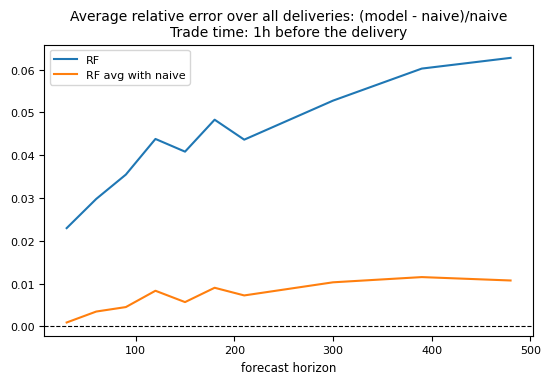

In [32]:
ttd_titles = ["1h"]
model = "random_forest"

ttd = 0

fig, ax = plt.subplots(figsize=(Image_width, 0.6 * Image_width))
for var_set in [11]:
    sum_dict = {}
    sum_dict_avg = {}
    counter_dict = {}
    sum_dict_naive = {}
    sum_dict_no_corr = {}
    for delivery in mae_results[model].keys():
        for horizon in [480, 390, 300, 210, 180, 150, 120, 90, 60, 30]:
            if horizon in mae_results[model][delivery].keys():
                if not (horizon in sum_dict.keys()):
                    sum_dict[horizon] = 0
                    sum_dict_avg[horizon] = 0
                    counter_dict[horizon] = 0
                    sum_dict_naive[horizon] = 0
                    sum_dict_no_corr[horizon] = 0
                # choose the trade time
                trade_times = []
                for trad in mae_results[model][delivery][horizon].keys():
                    if len(mae_results[model][delivery][horizon][trad]) > 0:
                        trade_times.append(trad)
                trade_time = trade_times[ttd]
                if (
                    len(mae_results[model][delivery][horizon][trade_time]) > 0
                    and "naive"
                    in mae_results[model][delivery][horizon][trade_time].keys()
                    and mae_results[model][delivery][horizon][trade_time]["naive"]
                ):
                    sum_dict[horizon] += mae_results[model][delivery][horizon][
                        trade_time
                    ][var_set]
                    sum_dict_avg[horizon] += mae_results[model][delivery][horizon][
                        trade_time
                    ][str(var_set) + "_avg"]
                    sum_dict_naive[horizon] += mae_results[model][delivery][horizon][
                        trade_time
                    ]["naive"]
                    # sum_dict_no_corr[horizon] +=  mae_results[model][delivery][horizon][trade_time]['no_correction'][var_set]
                    counter_dict[horizon] += 1

    plot_naive = []
    plot_corrected = []
    plot_corrected_avg = []
    # plot_uncorrected = []
    for horizon in [480, 390, 300, 210, 180, 150, 120, 90, 60, 30]:
        if counter_dict[horizon] == 0:
            plot_naive.append(np.nan)
            plot_corrected.append(np.nan)
            plot_corrected_avg.append(np.nan)
            # plot_uncorrected.append(np.nan)
        else:
            plot_naive.append(sum_dict_naive[horizon] / counter_dict[horizon])
            plot_corrected.append(sum_dict[horizon] / counter_dict[horizon])
            plot_corrected_avg.append(sum_dict_avg[horizon] / counter_dict[horizon])
            # plot_uncorrected.append(sum_dict_no_corr[horizon]/counter_dict[horizon])

    # ax.plot([480,390,300,210,180,150,120,90,60,30], (np.array(plot_uncorrected) - np.array(plot_naive))/np.array(plot_naive), label = f'Laplace SVR')
    ax.plot(
        [480, 390, 300, 210, 180, 150, 120, 90, 60, 30],
        (np.array(plot_corrected) - np.array(plot_naive)) / np.array(plot_naive),
        label=f"RF",
    )
    ax.plot(
        [480, 390, 300, 210, 180, 150, 120, 90, 60, 30],
        (np.array(plot_corrected_avg) - np.array(plot_naive)) / np.array(plot_naive),
        label=f"RF avg with naive",
    )
plt.axhline(0, color="black", ls="--", lw=0.8)
ax.legend()
ax.set_xlabel("forecast horizon")
ax.set_title(
    f"Average relative error over all deliveries: (model - naive)/naive\nTrade time: {ttd_titles[ttd - 1]} before the delivery"
)
# ax.set_ylabel("")
plt.savefig("../Paper_Figures/avg_relative_mae.pdf")

results with 0.8 thresh:

In [11]:
(np.array(plot_corrected_avg) - np.array(plot_naive)) / np.array(plot_naive)

array([-0.01638232, -0.01915046, -0.01963086, -0.01922521, -0.01901177,
       -0.01687976, -0.014434  , -0.01282906, -0.01170074, -0.01070002])

In [12]:
(np.array(plot_corrected_avg) - np.array(plot_naive)) / np.array(plot_naive)

array([-0.03084152])

0.4 0.6 weights:

In [4]:
(np.array(plot_corrected_avg) - np.array(plot_naive)) / np.array(plot_naive)

array([-0.02856942, -0.02304979, -0.02499816, -0.02761116, -0.03005462,
       -0.03031286, -0.02592091, -0.02236434, -0.0222709 , -0.01598095,
       -0.01135536])

0.6 0.4 weights

In [3]:
(np.array(plot_corrected_avg) - np.array(plot_naive)) / np.array(plot_naive)

array([-0.02863946, -0.02356671, -0.02545087, -0.02799646, -0.03062144,
       -0.03041745, -0.02646011, -0.02260763, -0.02219343, -0.01648856,
       -0.0117586 ])

In [27]:
(np.array(plot_corrected_avg) - np.array(plot_naive)) / np.array(plot_naive)

array([-0.02863946, -0.02356671, -0.02545087, -0.02799646, -0.03062144,
       -0.03084152, -0.02646011, -0.02260763, -0.02219343, -0.01648856,
       -0.0117586 ])

In [28]:
(np.array(plot_corrected_avg) - np.array(plot_naive)) / np.array(plot_naive)

array([-0.02972813])

In [33]:
for var_set in [11]:
    results_matrix = pd.DataFrame()

    for d, delivery in enumerate(mae_results[model].keys()):
        for h, horizon in enumerate(
            [480, 420, 360, 300, 240, 180, 150, 120, 90, 60, 30]
        ):
            if horizon in mae_results[model][delivery].keys():
                # choose the trade time
                trade_times = []
                for trad in mae_results[model][delivery][horizon].keys():
                    if len(mae_results[model][delivery][horizon][trad]) > 0:
                        trade_times.append(trad)
                trade_time = trade_times[ttd]
                if (
                    len(mae_results[model][delivery][horizon][trade_time]) > 0
                    and "naive"
                    in mae_results[model][delivery][horizon][trade_time].keys()
                    and mae_results[model][delivery][horizon][trade_time]["naive"]
                ):
                    results_matrix.loc[horizon, delivery * 0.25] = (
                        mae_results[model][delivery][horizon][trade_time][
                            str(var_set) + "_avg"
                        ]
                        - mae_results[model][delivery][horizon][trade_time]["naive"]
                    ) / mae_results[model][delivery][horizon][trade_time]["naive"]

In [12]:
for var_set in [11]:
    results_matrix = pd.DataFrame()

    for d, delivery in enumerate(mae_results[model].keys()):
        for h, horizon in enumerate(
            [480, 420, 360, 300, 240, 180, 150, 120, 90, 60, 30]
        ):
            if horizon in mae_results[model][delivery].keys():
                # choose the trade time
                trade_times = []
                for trad in mae_results[model][delivery][horizon].keys():
                    if len(mae_results[model][delivery][horizon][trad]) > 0:
                        trade_times.append(trad)
                trade_time = trade_times[ttd]
                if (
                    len(mae_results[model][delivery][horizon][trade_time]) > 0
                    and "corrected"
                    in mae_results[model][delivery][horizon][trade_time].keys()
                    and len(
                        mae_results[model][delivery][horizon][trade_time]["corrected"]
                    )
                    and "naive"
                    in mae_results[model][delivery][horizon][trade_time].keys()
                    and mae_results[model][delivery][horizon][trade_time]["naive"]
                ):
                    results_matrix.loc[horizon, delivery * 0.25] = (
                        mae_results[model][delivery][horizon][trade_time]["corrected"][
                            var_set
                        ]
                        - mae_results[model][delivery][horizon][trade_time]["naive"]
                    ) / mae_results[model][delivery][horizon][trade_time]["naive"]

In [26]:
np.where(np.isnan(results_matrix))

(array([2, 3, 4, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7,
        7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
        7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7], dtype=int64),
 array([80, 80, 80, 80,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12,
        13, 14,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14,
        15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31,
        32, 33, 34, 35, 36, 37, 38], dtype=int64))

In [15]:
np.where(np.diff(results_matrix.columns) != 0.25)

(array([], dtype=int64),)

<Axes: >

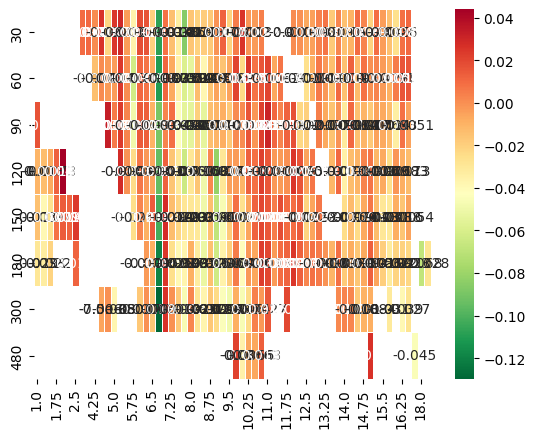

In [15]:
results_matrix

import seaborn as sns

# _r reverses the normal order of the color map 'RdYlGn'
sns.heatmap(results_matrix.sort_index(), cmap="RdYlGn_r", linewidths=0.5, annot=True)

<Axes: >

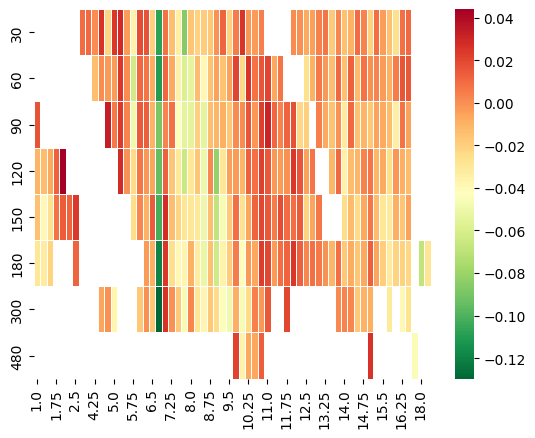

In [17]:
results_matrix

import seaborn as sns

# _r reverses the normal order of the color map 'RdYlGn'
sns.heatmap(results_matrix.sort_index(), cmap="RdYlGn_r", linewidths=0.5)

In [6]:
results_matrix = results_matrix.sort_index()

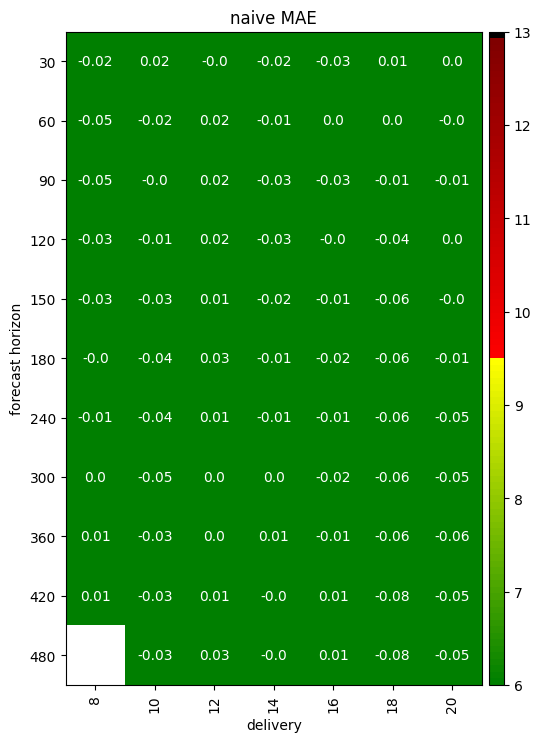

In [10]:
import matplotlib as mpl

results_matrix = results_matrix.sort_index()

red = np.concatenate([np.linspace(0, 1, 50), np.linspace(1, 0.5, 50)[1:], [0]])
green = np.concatenate([np.linspace(0.5, 1, 50), np.zeros(50)])
blue = np.zeros(100)
rgb_color_map = np.concatenate(
    [red.reshape(-1, 1), green.reshape(-1, 1), blue.reshape(-1, 1)], axis=1
)
rgb_color_map = mpl.colors.ListedColormap(rgb_color_map)

fig, ax = plt.subplots(figsize=(7.528125138889, 7.528125138889))
im = ax.imshow(results_matrix.astype(float).values, cmap=rgb_color_map, vmin=6, vmax=13)
ax.set_xticks(range(len(results_matrix.columns)), results_matrix.columns, rotation=90.0)
ax.set_yticks(range(len(results_matrix.index)), results_matrix.index)
ax.set_xlabel("delivery")
ax.set_ylabel("forecast horizon")
ax.set_title("naive MAE")
plt.tight_layout()
fig.subplots_adjust(right=0.9)
ax_pos = ax.get_position()
cbar_ax = fig.add_axes([ax_pos.x1 + 0.01, ax_pos.y0, 0.02, ax_pos.y1 - ax_pos.y0])
fig.colorbar(im, cax=cbar_ax, pad=0.5, shrink=0.4)

# Loop over data dimensions and create text annotations.
for i_idx, i in enumerate(results_matrix.index):
    for j_idx, j in enumerate(results_matrix.columns):
        text = ax.text(
            j_idx,
            i_idx,
            results_matrix.loc[i, j].round(2),
            ha="center",
            va="center",
            color="w",
        )

In [13]:
np.where(np.isnan(results_matrix))

(array([0, 1, 2, 3, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7,
        7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
        7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7], dtype=int64),
 array([80, 80, 80, 80,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12,
        13, 14,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14,
        15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31,
        32, 33, 34, 35, 36, 37, 38], dtype=int64))

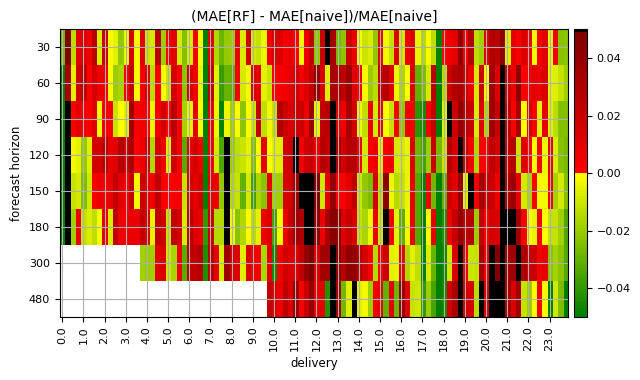

In [34]:
import matplotlib as mpl
import matplotlib.ticker as mtick

results_matrix = results_matrix.sort_index()

red = np.concatenate([np.linspace(0, 1, 50), np.linspace(1, 0.5, 50)[1:], [0]])
green = np.concatenate([np.linspace(0.5, 1, 50), np.zeros(50)])
blue = np.zeros(100)
rgb_color_map = np.concatenate(
    [red.reshape(-1, 1), green.reshape(-1, 1), blue.reshape(-1, 1)], axis=1
)
rgb_color_map = mpl.colors.ListedColormap(rgb_color_map)

fig, ax = plt.subplots(figsize=(Image_width, 0.6 * Image_width))
im = ax.imshow(
    results_matrix.astype(float).values,
    cmap=rgb_color_map,
    vmin=-0.05,
    vmax=0.05,
    aspect="auto",
)
ax.set_xticks(range(len(results_matrix.columns)), results_matrix.columns, rotation=90.0)
ax.set_yticks(range(len(results_matrix.index)), results_matrix.index)
ax.set_xlabel("delivery")
ax.set_ylabel("forecast horizon")
ax.set_title("(MAE[RF] - MAE[naive])/MAE[naive]")
ax.xaxis.set_major_locator(mtick.MultipleLocator(4))
ax.grid(True)
plt.tight_layout()
fig.subplots_adjust(right=0.9)
ax_pos = ax.get_position()
cbar_ax = fig.add_axes([ax_pos.x1 + 0.01, ax_pos.y0, 0.02, ax_pos.y1 - ax_pos.y0])
fig.colorbar(im, cax=cbar_ax, pad=0.5, shrink=0.4)

# Loop over data dimensions and create text annotations.
# for i_idx, i in enumerate(results_matrix.index):
#     for j_idx, j in enumerate(results_matrix.columns):
#         text = ax.text(j_idx, i_idx, results_matrix.loc[i, j].round(2),
#                        ha="center", va="center", color="w")
plt.savefig("../Paper_Figures/3D_relative_mae.pdf")

In [11]:
[i for i in range(80, 81)]

[80]

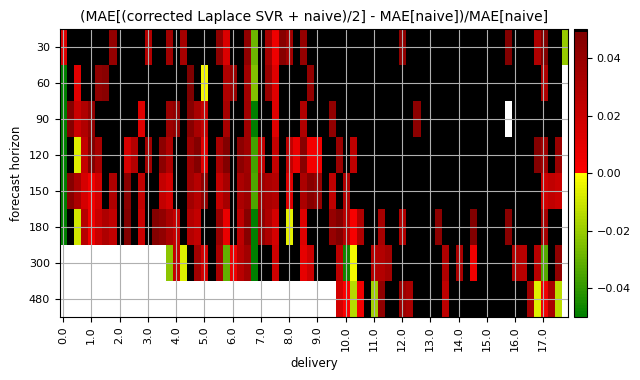

In [8]:
import matplotlib as mpl
import matplotlib.ticker as mtick

results_matrix = results_matrix.sort_index()

red = np.concatenate([np.linspace(0, 1, 50), np.linspace(1, 0.5, 50)[1:], [0]])
green = np.concatenate([np.linspace(0.5, 1, 50), np.zeros(50)])
blue = np.zeros(100)
rgb_color_map = np.concatenate(
    [red.reshape(-1, 1), green.reshape(-1, 1), blue.reshape(-1, 1)], axis=1
)
rgb_color_map = mpl.colors.ListedColormap(rgb_color_map)

fig, ax = plt.subplots(figsize=(Image_width, 0.6 * Image_width))
im = ax.imshow(
    results_matrix.astype(float).values,
    cmap=rgb_color_map,
    vmin=-0.05,
    vmax=0.05,
    aspect="auto",
)
ax.set_xticks(range(len(results_matrix.columns)), results_matrix.columns, rotation=90.0)
ax.set_yticks(range(len(results_matrix.index)), results_matrix.index)
ax.set_xlabel("delivery")
ax.set_ylabel("forecast horizon")
ax.set_title("(MAE[(corrected Laplace SVR + naive)/2] - MAE[naive])/MAE[naive]")
ax.xaxis.set_major_locator(mtick.MultipleLocator(4))
ax.grid(True)
plt.tight_layout()
fig.subplots_adjust(right=0.9)
ax_pos = ax.get_position()
cbar_ax = fig.add_axes([ax_pos.x1 + 0.01, ax_pos.y0, 0.02, ax_pos.y1 - ax_pos.y0])
fig.colorbar(im, cax=cbar_ax, pad=0.5, shrink=0.4)

# Loop over data dimensions and create text annotations.
# for i_idx, i in enumerate(results_matrix.index):
#     for j_idx, j in enumerate(results_matrix.columns):
#         text = ax.text(j_idx, i_idx, results_matrix.loc[i, j].round(2),
#                        ha="center", va="center", color="w")
plt.savefig("../Paper_Figures/3D_relative_mae.pdf")

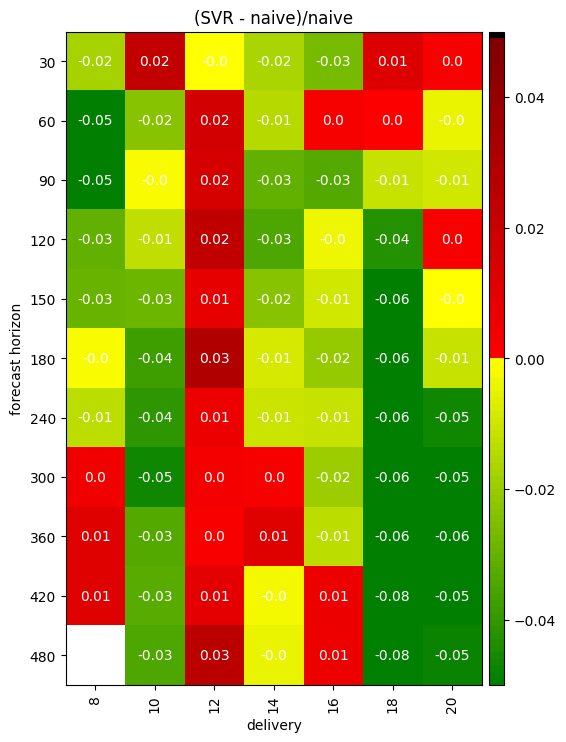

In [6]:
import matplotlib as mpl

results_matrix = results_matrix.sort_index()

red = np.concatenate([np.linspace(0, 1, 50), np.linspace(1, 0.5, 50)[1:], [0]])
green = np.concatenate([np.linspace(0.5, 1, 50), np.zeros(50)])
blue = np.zeros(100)
rgb_color_map = np.concatenate(
    [red.reshape(-1, 1), green.reshape(-1, 1), blue.reshape(-1, 1)], axis=1
)
rgb_color_map = mpl.colors.ListedColormap(rgb_color_map)

fig, ax = plt.subplots(figsize=(7.528125138889, 7.528125138889))
im = ax.imshow(
    results_matrix.astype(float).values, cmap=rgb_color_map, vmin=-0.05, vmax=0.05
)
ax.set_xticks(range(len(results_matrix.columns)), results_matrix.columns, rotation=90.0)
ax.set_yticks(range(len(results_matrix.index)), results_matrix.index)
ax.set_xlabel("delivery")
ax.set_ylabel("forecast horizon")
ax.set_title("(SVR - naive)/naive")
plt.tight_layout()
fig.subplots_adjust(right=0.9)
ax_pos = ax.get_position()
cbar_ax = fig.add_axes([ax_pos.x1 + 0.01, ax_pos.y0, 0.02, ax_pos.y1 - ax_pos.y0])
fig.colorbar(im, cax=cbar_ax, pad=0.5, shrink=0.4)

# Loop over data dimensions and create text annotations.
for i_idx, i in enumerate(results_matrix.index):
    for j_idx, j in enumerate(results_matrix.columns):
        text = ax.text(
            j_idx,
            i_idx,
            results_matrix.loc[i, j].round(2),
            ha="center",
            va="center",
            color="w",
        )

lasso_speedup_2020-01-01_2020-12-31_427_32_[480]_900_True_True_True


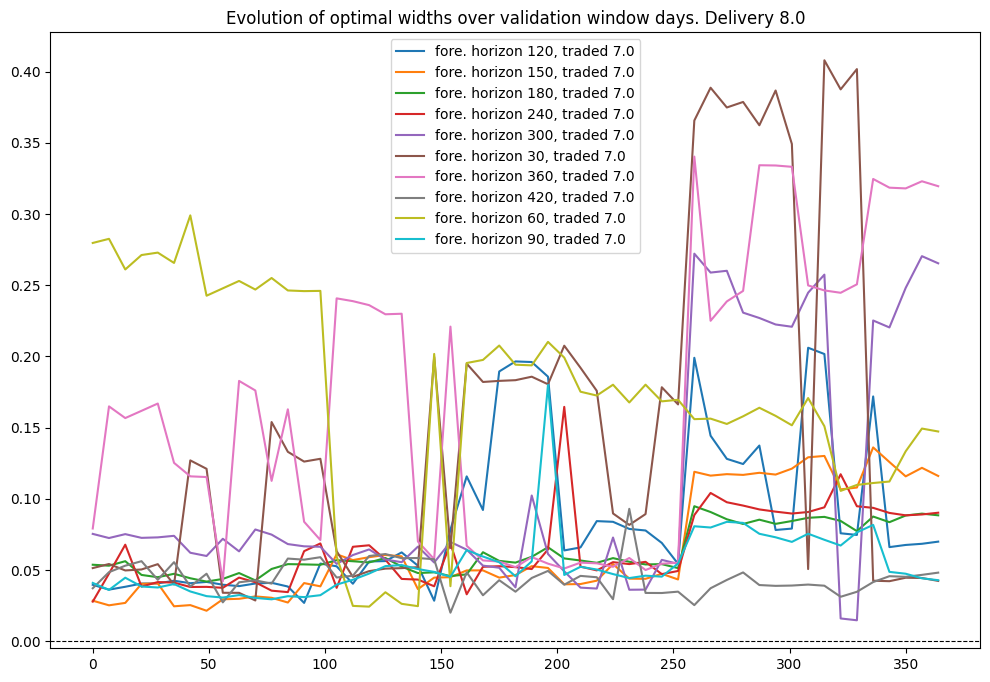

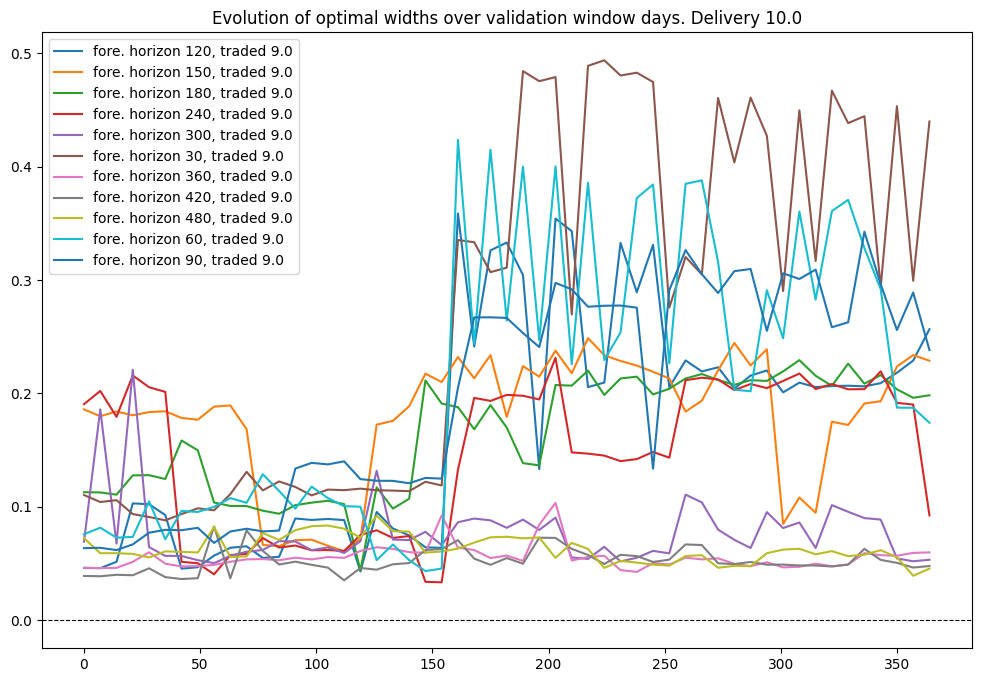

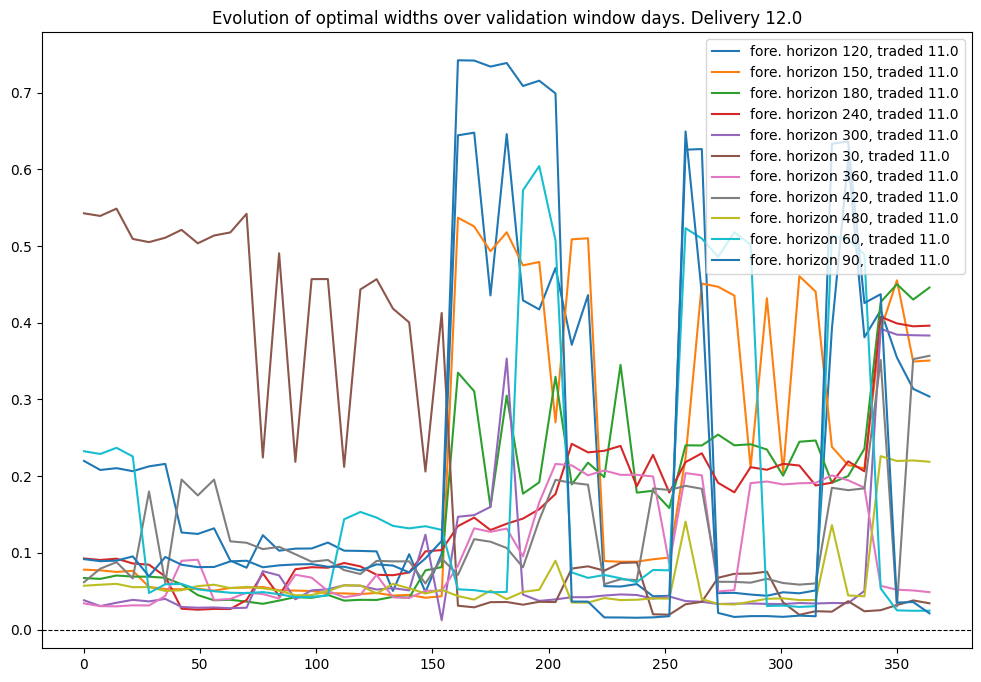

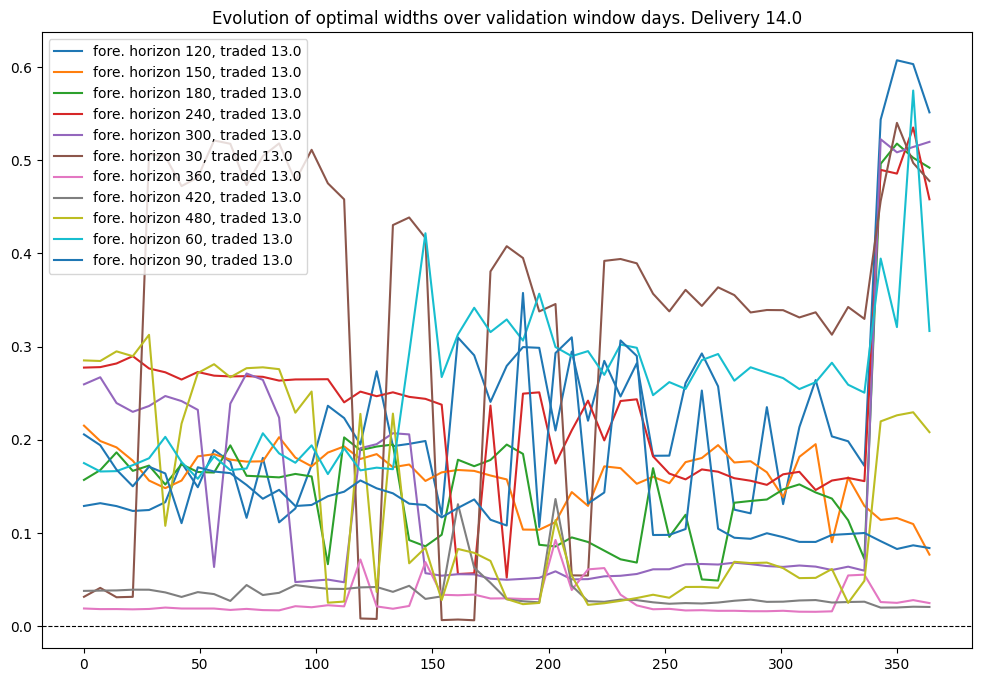

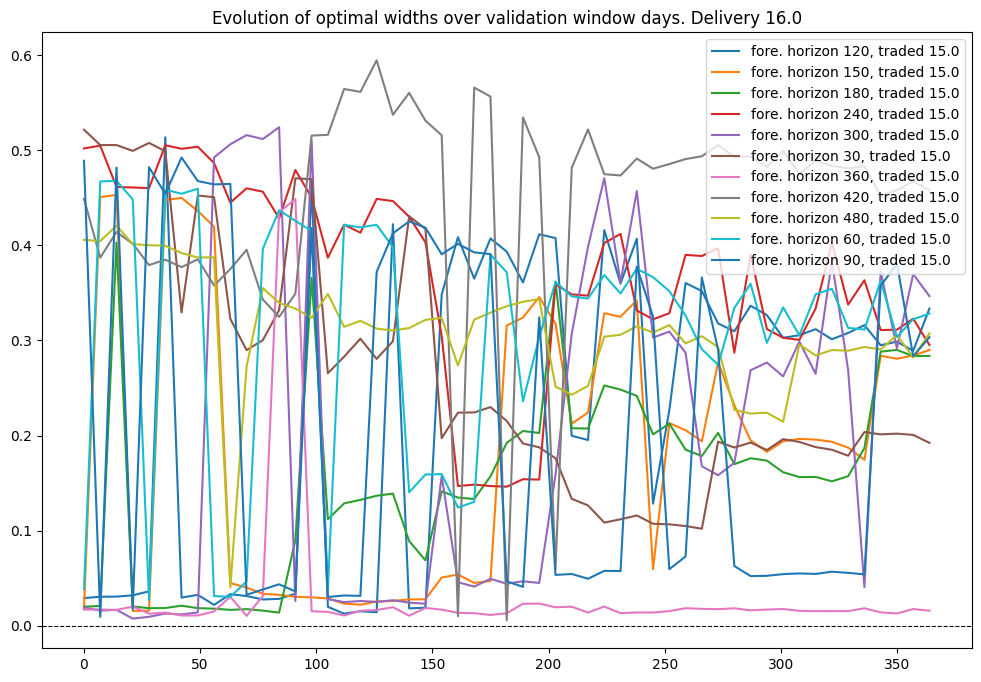

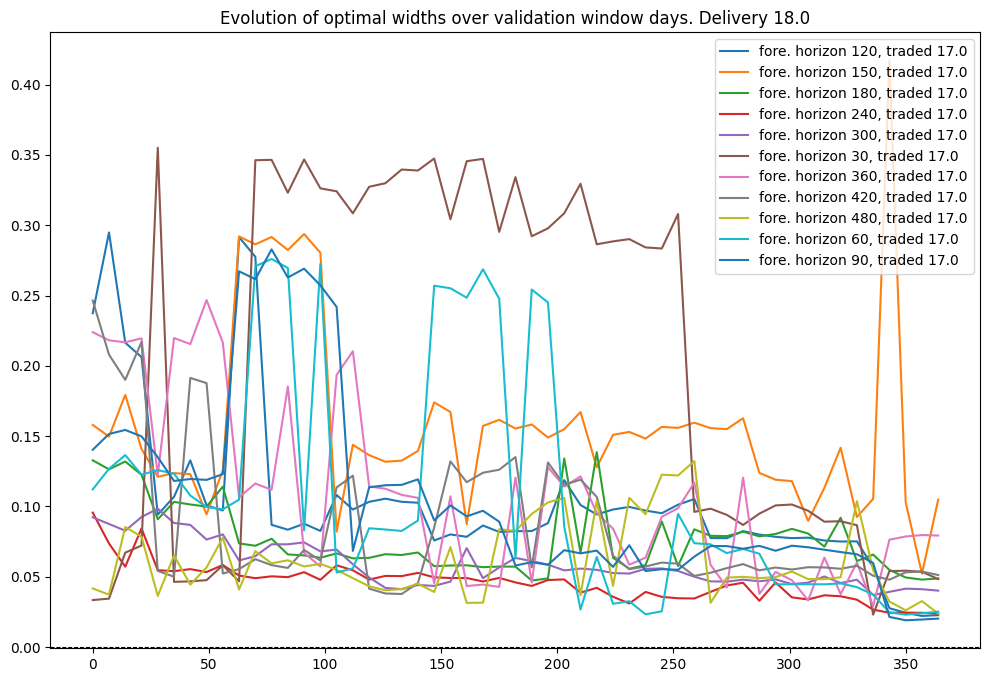

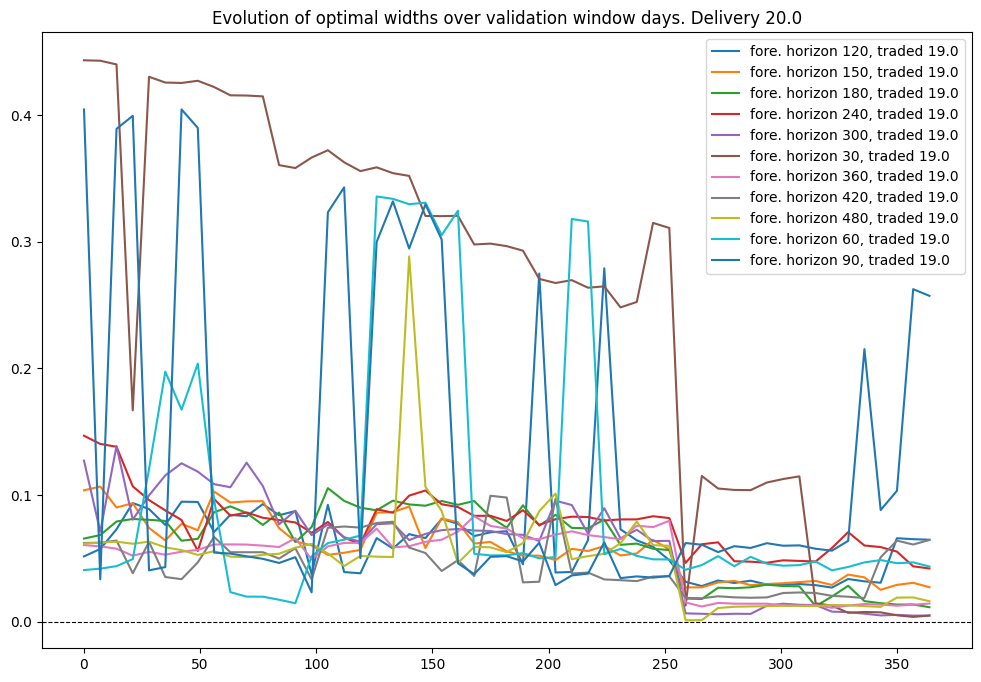

In [2]:
for delivery in [32, 40, 48, 56, 64, 72, 80]:
    fig, ax = plt.subplots(figsize=(12, 8))
    for direct in os.listdir("Forecasts"):
        if "lasso_speedup" in direct and f"_{delivery}_" in direct:
            try:
                pickled_cv_results = [
                    i
                    for i in os.listdir(os.path.join("Forecasts", direct))
                    if "pickle" in i
                ]
                optimal_widths = pickle.load(
                    open(os.path.join("Forecasts", direct, pickled_cv_results[0]), "rb")
                )

                idxs = []
                lam = []
                for i in optimal_widths.keys():
                    idxs.append(i)
                    lam.append(optimal_widths[i])

                ax.plot(
                    idxs,
                    lam,
                    label=f"fore. horizon {direct.split('_[')[1].split(']_')[0]}, traded {int(direct.split(']_')[1].split('_')[0]) / 60 - 8}",
                )
            except:
                print(direct)

    ax.set_title(
        f"Evolution of optimal widths over validation window days. Delivery {delivery / 4}"
    )
    plt.axhline(0, color="black", ls="--", lw=0.8)
    ax.legend()

In [ ]:
for direct in os.listdir("Forecasts"):
    if "kernel_hr_naive_mult_CV" in direct:
        try:
            pickled_cv_results = [
                i
                for i in os.listdir(os.path.join("Forecasts", direct))
                if "pickle" in i
            ]
            optimal_widths = pickle.load(
                open(os.path.join("Forecasts", direct, pickled_cv_results[0]), "rb")
            )

            idxs = []
            h_1 = []
            h_2 = []
            for i in optimal_widths.keys():
                idxs.append(i)
                h_1.append(optimal_widths[i][0])
                h_2.append(optimal_widths[i][1])

            fig, ax = plt.subplots(figsize=(10, 5))
            ax.plot(idxs, h_1)
            ax.plot(idxs, h_2)
            ax.axhline(0, ls="--", color="black")
            ax.legend(["laplacian width (h_1)", "target correction width (h_2)"])
            ax.set_title(
                f"Evolution of optimal widths over validation window days. Horizon {direct.split('_[')[1].split(']_')[0]}, traded {int(direct.split(']_')[1].split('_')[0]) / 60 - 8}, delivery {int(direct.split('_[')[0].split('_')[-1]) / 4}"
            )
        except:
            print(direct)

In [30]:
recalc = True


def my_rmse(X, Y):
    return np.sqrt(((X - Y) ** 2).mean())


def my_mae(X, Y):
    return np.mean(np.abs(X - Y))

In [31]:
results_dirs = os.listdir("Forecasts")

In [35]:
models = [
    "kernel_hr_naive_mult"
]  # np.unique([dir_name.split('_2020')[0] for dir_name in results_dirs])
deliveries = np.unique(
    [int(dir_name.split("_427_")[1].split("_")[0]) for dir_name in results_dirs]
)
horizons = np.unique(
    [
        int(dir_name.split("_427_")[1].split("_")[1].replace("[", "").replace("]", ""))
        for dir_name in results_dirs
    ]
)

trade_times = []
for delivery in deliveries:
    delivery_dirs = [
        resul_dir for resul_dir in results_dirs if f"_{delivery}_" in resul_dir
    ]
    for delivery_dir in delivery_dirs:
        trade_times.append(int(delivery_dir.split(f"]_")[1].split("_")[0]))
trade_times = np.unique(trade_times)

In [36]:
models

['kernel_hr_naive_mult']

In [37]:
# if recalc:
#     mae_results = {}

#     for model in models:

#         mae_results[model] = {}

#         for delivery in deliveries:
#             print(delivery)
#             mae_results[model][delivery] = {}
#             for horizon in horizons:
#                 mae_results[model][delivery][horizon] = {}
#                 for trade_time in trade_times:
#                     mae_results[model][delivery][horizon][trade_time] = {}

#                     fore_dir = f"{model}_2020-01-01_2020-12-31_427_{delivery}_[{horizon}]_{trade_time}_True_True_True"

#                     if os.path.exists(os.path.join("Forecasts", fore_dir)):
#                         forecasts = [f for f in os.listdir(os.path.join("Forecasts", fore_dir)) if 'pickle' not in f and 'npy' not in f]


#                         if model == 'kernel_hr_naive_mult' or 'kernel_hr_naive_mult_CV':
#                             for model_type in ['corrected', 'no_correction']:
#                                 mae_results[model][delivery][horizon][trade_time][model_type] = {}
#                                 mae_results[model][delivery][horizon][trade_time][model_type + '_avg'] = {}
#                                 for var_set in [11,12]:
#                                     actual = []
#                                     forecast = []
#                                     naive = []
#                                     for fore in forecasts:
#                                         if int(fore.split('_' + str(horizon) + '_')[1].split('_')[0]) == var_set:
#                                             if model_type == 'corrected':
#                                                 if not 'no_correction' in fore:
#                                                     df = pd.read_csv(os.path.join("Forecasts", fore_dir, fore))
#                                                     actual.append(df.loc[0,'actual'])
#                                                     forecast.append(df.loc[0,'prediction'])
#                                                     naive.append(df.loc[0,'naive'])
#                                             else:
#                                                 if 'no_correction' in fore:
#                                                     df = pd.read_csv(os.path.join("Forecasts", fore_dir, fore))
#                                                     actual.append(df.loc[0,'actual'])
#                                                     forecast.append(df.loc[0,'prediction'])
#                                                     naive.append(df.loc[0,'naive'])

#                                     if len(actual) == 366:
#                                         mae_results[model][delivery][horizon][trade_time][model_type][var_set] = my_mae(np.array(actual), np.array(forecast))
#                                         mae_results[model][delivery][horizon][trade_time][model_type + '_avg'][var_set] = my_mae(np.array(actual), (np.array(forecast) + np.array(naive))/2)
#                                         mae_results[model][delivery][horizon][trade_time]['naive'] = my_mae(np.array(actual), np.array(naive))

#                         else:
#                             for var_set in [11]:
#                                 actual = []
#                                 forecast = []
#                                 naive = []
#                                 for fore in forecasts:
#                                     if int(fore.split('_' + str(horizon) + '_')[1].split('_')[0]) == var_set:
#                                         df = pd.read_csv(os.path.join("Forecasts", fore_dir, fore))
#                                         actual.append(df.loc[0,'actual'])
#                                         forecast.append(df.loc[0,'prediction'])
#                                         naive.append(df.loc[0,'naive'])

#                                 if len(actual) == 366:
#                                     mae_results[model][delivery][horizon][trade_time][var_set] = my_mae(np.array(actual), np.array(forecast))
#                                     mae_results[model][delivery][horizon][trade_time][str(var_set) + '_avg'] = my_mae(np.array(actual), (np.array(forecast) + np.array(naive))/2)
#                                     mae_results[model][delivery][horizon][trade_time]['naive'] = my_mae(np.array(actual), np.array(naive))

#     pickle.dump(mae_results, open('mae_results.pickle', 'wb'))
# else:
#     mae_results = pickle.load(open('mae_results.pickle', 'rb'))


In [38]:
if recalc:
    mae_results = {}

    for model in models:
        mae_results[model] = {}

        for delivery in deliveries:
            print(delivery)
            mae_results[model][delivery] = {}
            for horizon in horizons:
                mae_results[model][delivery][horizon] = {}
                for trade_time in trade_times:
                    mae_results[model][delivery][horizon][trade_time] = {}

                    fore_dir = f"{model}_2020-01-01_2020-12-31_427_{delivery}_[{horizon}]_{trade_time}_True_True_True"

                    if os.path.exists(os.path.join("Forecasts", fore_dir)):
                        forecasts = [
                            f
                            for f in os.listdir(os.path.join("Forecasts", fore_dir))
                            if "pickle" not in f and "npy" not in f
                        ]

                        if model == "kernel_hr_naive_mult" or "kernel_hr_naive_mult_CV":
                            for model_type in ["corrected", "no_correction"]:
                                mae_results[model][delivery][horizon][trade_time][
                                    model_type
                                ] = {}
                                mae_results[model][delivery][horizon][trade_time][
                                    model_type + "_avg"
                                ] = {}
                                for var_set in [11, 12]:
                                    actual = []
                                    forecast = []
                                    naive = []
                                    for fore in forecasts:
                                        if "_window_180" not in fore:
                                            continue
                                        if (
                                            int(
                                                fore.split("_" + str(horizon) + "_")[
                                                    1
                                                ].split("_")[0]
                                            )
                                            == var_set
                                        ):
                                            if model_type == "corrected":
                                                if not "no_correction" in fore:
                                                    df = pd.read_csv(
                                                        os.path.join(
                                                            "Forecasts", fore_dir, fore
                                                        )
                                                    )
                                                    actual.append(df.loc[0, "actual"])
                                                    forecast.append(
                                                        df.loc[0, "prediction"]
                                                    )
                                                    naive.append(df.loc[0, "naive"])
                                            else:
                                                if "no_correction" in fore:
                                                    df = pd.read_csv(
                                                        os.path.join(
                                                            "Forecasts", fore_dir, fore
                                                        )
                                                    )
                                                    actual.append(df.loc[0, "actual"])
                                                    forecast.append(
                                                        df.loc[0, "prediction"]
                                                    )
                                                    naive.append(df.loc[0, "naive"])

                                    if len(actual) == 366:
                                        mae_results[model][delivery][horizon][
                                            trade_time
                                        ][model_type][var_set] = my_mae(
                                            np.array(actual), np.array(forecast)
                                        )
                                        mae_results[model][delivery][horizon][
                                            trade_time
                                        ][model_type + "_avg"][var_set] = my_mae(
                                            np.array(actual),
                                            (np.array(forecast) + np.array(naive)) / 2,
                                        )
                                        mae_results[model][delivery][horizon][
                                            trade_time
                                        ]["naive"] = my_mae(
                                            np.array(actual), np.array(naive)
                                        )

                        else:
                            for var_set in [11]:
                                actual = []
                                forecast = []
                                naive = []
                                for fore in forecasts:
                                    if (
                                        int(
                                            fore.split("_" + str(horizon) + "_")[
                                                1
                                            ].split("_")[0]
                                        )
                                        == var_set
                                    ):
                                        df = pd.read_csv(
                                            os.path.join("Forecasts", fore_dir, fore)
                                        )
                                        actual.append(df.loc[0, "actual"])
                                        forecast.append(df.loc[0, "prediction"])
                                        naive.append(df.loc[0, "naive"])

                                if len(actual) == 366:
                                    mae_results[model][delivery][horizon][trade_time][
                                        var_set
                                    ] = my_mae(np.array(actual), np.array(forecast))
                                    mae_results[model][delivery][horizon][trade_time][
                                        str(var_set) + "_avg"
                                    ] = my_mae(
                                        np.array(actual),
                                        (np.array(forecast) + np.array(naive)) / 2,
                                    )
                                    mae_results[model][delivery][horizon][trade_time][
                                        "naive"
                                    ] = my_mae(np.array(actual), np.array(naive))

    pickle.dump(mae_results, open("mae_results.pickle", "wb"))
else:
    mae_results = pickle.load(open("mae_results.pickle", "rb"))

32
40


(-0.1, 0.1)

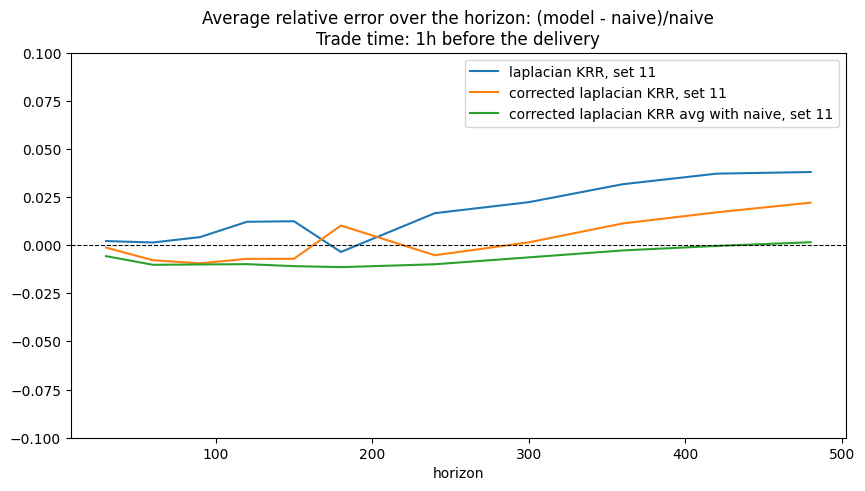

In [ ]:
ttd_titles = ["1h"]
model = "kernel_hr_naive_mult"

ttd = 1

fig, ax = plt.subplots(figsize=(10, 5))
for var_set in [11]:
    sum_dict = {}
    sum_dict_avg = {}
    counter_dict = {}
    sum_dict_naive = {}
    sum_dict_no_corr = {}
    for delivery in mae_results[model].keys():
        for horizon in [480, 420, 360, 300, 240, 180, 150, 120, 90, 60, 30]:
            if horizon in mae_results[model][delivery].keys():
                if not (horizon in sum_dict.keys()):
                    sum_dict[horizon] = 0
                    sum_dict_avg[horizon] = 0
                    counter_dict[horizon] = 0
                    sum_dict_naive[horizon] = 0
                    sum_dict_no_corr[horizon] = 0
                # choose the trade time
                trade_times = []
                for trad in mae_results[model][delivery][horizon].keys():
                    if len(mae_results[model][delivery][horizon][trad]) > 0:
                        trade_times.append(trad)
                trade_time = trade_times[ttd]
                if (
                    len(mae_results[model][delivery][horizon][trade_time]) > 0
                    and len(
                        mae_results[model][delivery][horizon][trade_time]["corrected"]
                    )
                    and mae_results[model][delivery][horizon][trade_time]["naive"]
                ):
                    sum_dict[horizon] += mae_results[model][delivery][horizon][
                        trade_time
                    ]["corrected"][var_set]
                    sum_dict_avg[horizon] += mae_results[model][delivery][horizon][
                        trade_time
                    ]["corrected_avg"][var_set]
                    sum_dict_naive[horizon] += mae_results[model][delivery][horizon][
                        trade_time
                    ]["naive"]
                    sum_dict_no_corr[horizon] += mae_results[model][delivery][horizon][
                        trade_time
                    ]["no_correction"][var_set]
                    counter_dict[horizon] += 1

    plot_naive = []
    plot_corrected = []
    plot_corrected_avg = []
    plot_uncorrected = []
    for horizon in [480, 420, 360, 300, 240, 180, 150, 120, 90, 60, 30]:
        if counter_dict[horizon] == 0:
            plot_naive.append(np.nan)
            plot_corrected.append(np.nan)
            plot_uncorrected.append(np.nan)
        else:
            plot_naive.append(sum_dict_naive[horizon] / counter_dict[horizon])
            plot_corrected.append(sum_dict[horizon] / counter_dict[horizon])
            plot_corrected_avg.append(sum_dict_avg[horizon] / counter_dict[horizon])
            plot_uncorrected.append(sum_dict_no_corr[horizon] / counter_dict[horizon])

    ax.plot(
        [480, 420, 360, 300, 240, 180, 150, 120, 90, 60, 30],
        (np.array(plot_uncorrected) - np.array(plot_naive)) / np.array(plot_naive),
        label=f"laplacian KRR, set {var_set}",
    )
    ax.plot(
        [480, 420, 360, 300, 240, 180, 150, 120, 90, 60, 30],
        (np.array(plot_corrected) - np.array(plot_naive)) / np.array(plot_naive),
        label=f"corrected laplacian KRR, set {var_set}",
    )
    ax.plot(
        [480, 420, 360, 300, 240, 180, 150, 120, 90, 60, 30],
        (np.array(plot_corrected_avg) - np.array(plot_naive)) / np.array(plot_naive),
        label=f"corrected laplacian KRR avg with naive, set {var_set}",
    )
plt.axhline(0, color="black", ls="--", lw=0.8)
ax.legend()
ax.set_xlabel("horizon")
ax.set_title(
    f"Average relative error over the horizon: (model - naive)/naive\nTrade time: {ttd_titles[ttd - 1]} before the delivery"
)
ax.set_ylim([-0.1, 0.1])

In [12]:
(np.array(plot_corrected) - np.array(plot_naive)) / np.array(plot_naive)

array([ 0.02211717,  0.01708558,  0.01130878,  0.00149276, -0.00521223,
       -0.02450155, -0.00705359, -0.00707341, -0.00940283, -0.00780496,
       -0.00123387])

In [108]:
(np.array(plot_corrected) - np.array(plot_naive)) / np.array(plot_naive)

array([ 0.02211717,  0.01708558,  0.01130878,  0.00149276, -0.00521223,
       -0.02469985, -0.00705359, -0.00707341, -0.00940283, -0.00780496,
       -0.00123387])

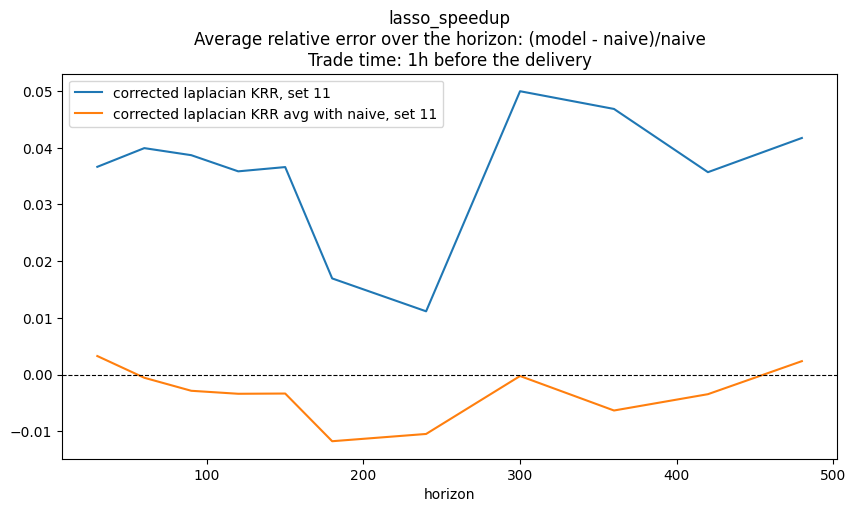

In [68]:
ttd_titles = ["1h"]
for model in ["lasso_speedup"]:
    for ttd in range(1):
        fig, ax = plt.subplots(figsize=(10, 5))
        for var_set in [11]:
            sum_dict = {}
            sum_dict_avg = {}
            counter_dict = {}
            sum_dict_naive = {}
            sum_dict_no_corr = {}
            for delivery in mae_results[model].keys():
                for horizon in [480, 420, 360, 300, 240, 180, 150, 120, 90, 60, 30]:
                    if horizon in mae_results[model][delivery].keys():
                        if not (horizon in sum_dict.keys()):
                            sum_dict[horizon] = 0
                            sum_dict_avg[horizon] = 0
                            counter_dict[horizon] = 0
                            sum_dict_naive[horizon] = 0
                            sum_dict_no_corr[horizon] = 0
                        # choose the trade time
                        trade_times = []
                        for trad in mae_results[model][delivery][horizon].keys():
                            if len(mae_results[model][delivery][horizon][trad]) > 0:
                                trade_times.append(trad)
                        if len(trade_times) > ttd:
                            trade_time = trade_times[ttd]
                            if (
                                len(mae_results[model][delivery][horizon][trade_time])
                                > 0
                                and len(
                                    mae_results[model][delivery][horizon][trade_time]
                                )
                                and mae_results[model][delivery][horizon][trade_time][
                                    "naive"
                                ]
                            ):
                                sum_dict[horizon] += mae_results[model][delivery][
                                    horizon
                                ][trade_time][var_set]
                                sum_dict_avg[horizon] += mae_results[model][delivery][
                                    horizon
                                ][trade_time][str(var_set) + "_avg"]
                                sum_dict_naive[horizon] += mae_results[model][delivery][
                                    horizon
                                ][trade_time]["naive"]
                                # sum_dict_no_corr[horizon] +=  mae_results[model][delivery][horizon][trade_time]['no_correction'][var_set]
                                counter_dict[horizon] += 1

            plot_naive = []
            plot_corrected = []
            plot_corrected_avg = []
            plot_uncorrected = []
            for horizon in [480, 420, 360, 300, 240, 180, 150, 120, 90, 60, 30]:
                if counter_dict[horizon] == 0:
                    plot_naive.append(np.nan)
                    plot_corrected.append(np.nan)
                    plot_uncorrected.append(np.nan)
                else:
                    plot_naive.append(sum_dict_naive[horizon] / counter_dict[horizon])
                    plot_corrected.append(sum_dict[horizon] / counter_dict[horizon])
                    plot_corrected_avg.append(
                        sum_dict_avg[horizon] / counter_dict[horizon]
                    )
                    plot_uncorrected.append(
                        sum_dict_no_corr[horizon] / counter_dict[horizon]
                    )

            # ax.plot([480,420,360,300,240,180,150,120,90,60,30], (np.array(plot_uncorrected) - np.array(plot_naive))/np.array(plot_naive), label = f'laplacian KRR, set {var_set}')
            ax.plot(
                [480, 420, 360, 300, 240, 180, 150, 120, 90, 60, 30],
                (np.array(plot_corrected) - np.array(plot_naive))
                / np.array(plot_naive),
                label=f"corrected laplacian KRR, set {var_set}",
            )
            ax.plot(
                [480, 420, 360, 300, 240, 180, 150, 120, 90, 60, 30],
                (np.array(plot_corrected_avg) - np.array(plot_naive))
                / np.array(plot_naive),
                label=f"corrected laplacian KRR avg with naive, set {var_set}",
            )
        plt.axhline(0, color="black", ls="--", lw=0.8)
        ax.legend()
        ax.set_xlabel("horizon")
        ax.set_title(
            f"{model}\nAverage relative error over the horizon: (model - naive)/naive\nTrade time: {ttd_titles[ttd]} before the delivery"
        )

In [78]:
mae_results

{'kernel_hr_naive_mult_CV': {32: {30: {840: {},
    900: {},
    930: {},
    960: {},
    1020: {},
    1050: {},
    1080: {},
    1140: {},
    1170: {},
    1200: {},
    1260: {},
    1290: {},
    1320: {},
    1380: {},
    1410: {},
    1440: {},
    1500: {},
    1530: {},
    1560: {},
    1620: {},
    1650: {}},
   60: {840: {},
    900: {},
    930: {},
    960: {},
    1020: {},
    1050: {},
    1080: {},
    1140: {},
    1170: {},
    1200: {},
    1260: {},
    1290: {},
    1320: {},
    1380: {},
    1410: {},
    1440: {},
    1500: {},
    1530: {},
    1560: {},
    1620: {},
    1650: {}},
   90: {840: {},
    900: {},
    930: {},
    960: {},
    1020: {},
    1050: {},
    1080: {},
    1140: {},
    1170: {},
    1200: {},
    1260: {},
    1290: {},
    1320: {},
    1380: {},
    1410: {},
    1440: {},
    1500: {},
    1530: {},
    1560: {},
    1620: {},
    1650: {}},
   120: {840: {},
    900: {},
    930: {},
    960: {},
    1020: {},
    1050: {},

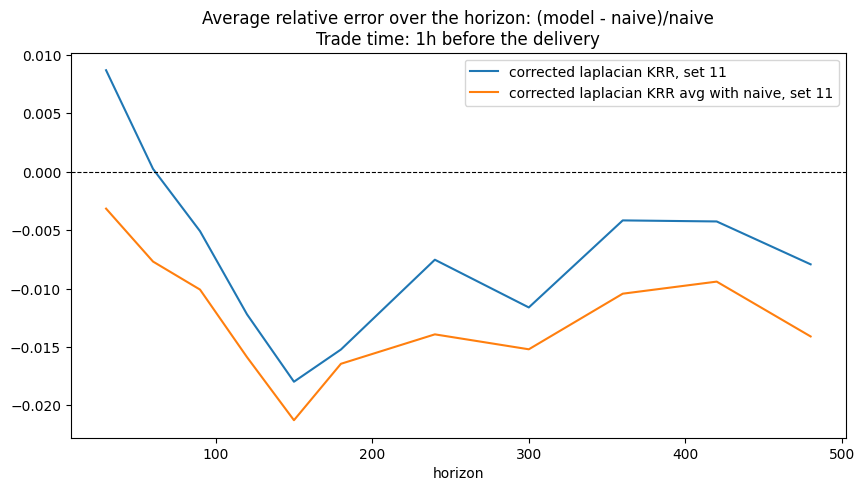

In [10]:
ttd_titles = ["1h"]
model = "kernel_hr_naive_mult_CV"
for ttd in range(1):
    fig, ax = plt.subplots(figsize=(10, 5))
    for var_set in [11]:
        sum_dict = {}
        sum_dict_avg = {}
        counter_dict = {}
        sum_dict_naive = {}
        sum_dict_no_corr = {}
        for delivery in mae_results[model].keys():
            for horizon in [480, 420, 360, 300, 240, 180, 150, 120, 90, 60, 30]:
                if horizon in mae_results[model][delivery].keys():
                    if not (horizon in sum_dict.keys()):
                        sum_dict[horizon] = 0
                        sum_dict_avg[horizon] = 0
                        counter_dict[horizon] = 0
                        sum_dict_naive[horizon] = 0
                        sum_dict_no_corr[horizon] = 0
                    # choose the trade time
                    trade_times = []
                    for trad in mae_results[model][delivery][horizon].keys():
                        if len(mae_results[model][delivery][horizon][trad]) > 0:
                            trade_times.append(trad)
                    trade_time = trade_times[ttd]
                    if (
                        len(mae_results[model][delivery][horizon][trade_time]) > 0
                        and len(
                            mae_results[model][delivery][horizon][trade_time][
                                "corrected"
                            ]
                        )
                        and mae_results[model][delivery][horizon][trade_time]["naive"]
                    ):
                        sum_dict[horizon] += mae_results[model][delivery][horizon][
                            trade_time
                        ]["corrected"][var_set]
                        sum_dict_avg[horizon] += mae_results[model][delivery][horizon][
                            trade_time
                        ]["corrected_avg"][var_set]
                        sum_dict_naive[horizon] += mae_results[model][delivery][
                            horizon
                        ][trade_time]["naive"]
                        sum_dict_no_corr[horizon] += mae_results[model][delivery][
                            horizon
                        ][trade_time]["no_correction"][var_set]
                        counter_dict[horizon] += 1

        plot_naive = []
        plot_corrected = []
        plot_corrected_avg = []
        plot_uncorrected = []
        for horizon in [480, 420, 360, 300, 240, 180, 150, 120, 90, 60, 30]:
            if counter_dict[horizon] == 0:
                plot_naive.append(np.nan)
                plot_corrected.append(np.nan)
                plot_uncorrected.append(np.nan)
            else:
                plot_naive.append(sum_dict_naive[horizon] / counter_dict[horizon])
                plot_corrected.append(sum_dict[horizon] / counter_dict[horizon])
                plot_corrected_avg.append(sum_dict_avg[horizon] / counter_dict[horizon])
                plot_uncorrected.append(
                    sum_dict_no_corr[horizon] / counter_dict[horizon]
                )

        # ax.plot([480,420,360,300,240,180,150,120,90,60,30], (np.array(plot_uncorrected) - np.array(plot_naive))/np.array(plot_naive), label = f'laplacian KRR, set {var_set}')
        ax.plot(
            [480, 420, 360, 300, 240, 180, 150, 120, 90, 60, 30],
            (np.array(plot_corrected) - np.array(plot_naive)) / np.array(plot_naive),
            label=f"corrected laplacian KRR, set {var_set}",
        )
        ax.plot(
            [480, 420, 360, 300, 240, 180, 150, 120, 90, 60, 30],
            (np.array(plot_corrected_avg) - np.array(plot_naive))
            / np.array(plot_naive),
            label=f"corrected laplacian KRR avg with naive, set {var_set}",
        )
    plt.axhline(0, color="black", ls="--", lw=0.8)
    ax.legend()
    ax.set_xlabel("horizon")
    ax.set_title(
        f"Average relative error over the horizon: (model - naive)/naive\nTrade time: {ttd_titles[ttd]} before the delivery"
    )

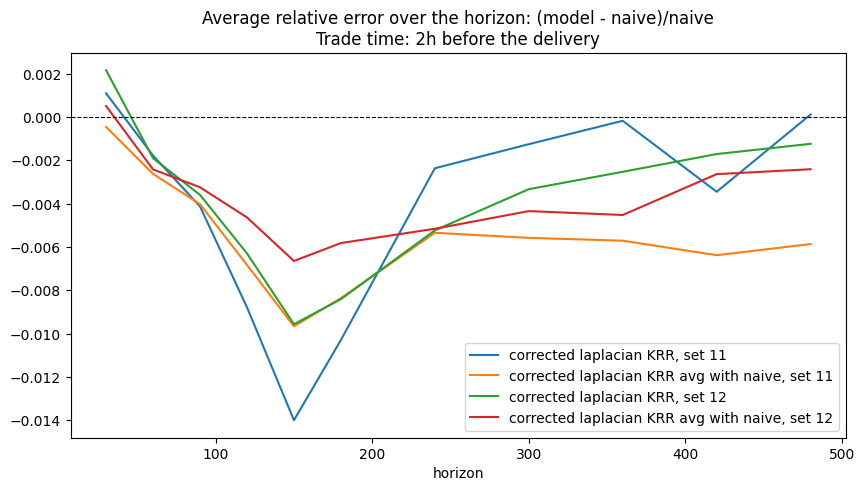

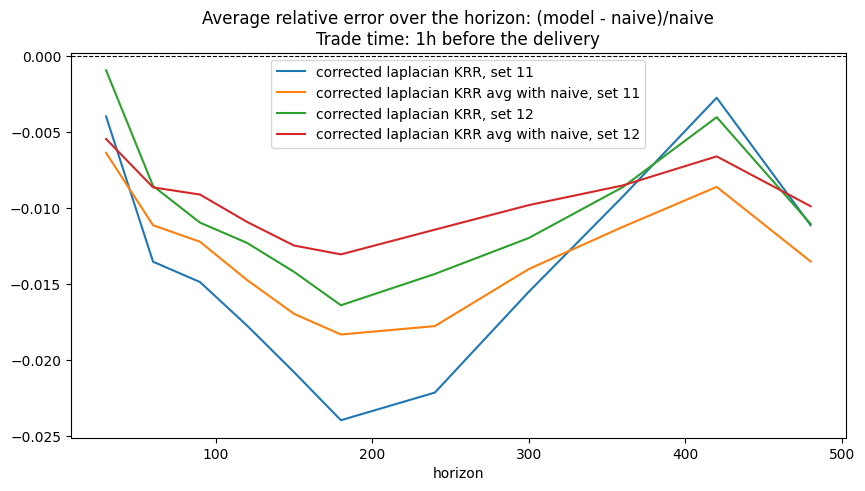

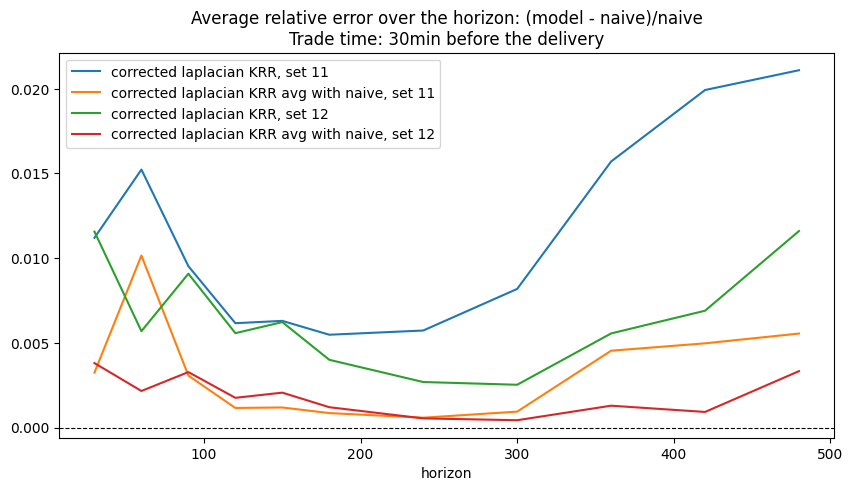

In [90]:
ttd_titles = ["2h", "1h", "30min"]
model = "kernel_hr_naive_mult"
for ttd in range(3):
    fig, ax = plt.subplots(figsize=(10, 5))
    for var_set in [11, 12]:
        sum_dict = {}
        sum_dict_avg = {}
        counter_dict = {}
        sum_dict_naive = {}
        sum_dict_no_corr = {}
        for delivery in mae_results[model].keys():
            for horizon in [480, 420, 360, 300, 240, 180, 150, 120, 90, 60, 30]:
                if horizon in mae_results[model][delivery].keys():
                    if not (horizon in sum_dict.keys()):
                        sum_dict[horizon] = 0
                        sum_dict_avg[horizon] = 0
                        counter_dict[horizon] = 0
                        sum_dict_naive[horizon] = 0
                        sum_dict_no_corr[horizon] = 0
                    # choose the trade time
                    trade_times = []
                    for trad in mae_results[model][delivery][horizon].keys():
                        if len(mae_results[model][delivery][horizon][trad]) > 0:
                            trade_times.append(trad)
                    trade_time = trade_times[ttd]
                    if (
                        len(mae_results[model][delivery][horizon][trade_time]) > 0
                        and len(
                            mae_results[model][delivery][horizon][trade_time][
                                "corrected"
                            ]
                        )
                        and mae_results[model][delivery][horizon][trade_time]["naive"]
                    ):
                        sum_dict[horizon] += mae_results[model][delivery][horizon][
                            trade_time
                        ]["corrected"][var_set]
                        sum_dict_avg[horizon] += mae_results[model][delivery][horizon][
                            trade_time
                        ]["corrected_avg"][var_set]
                        sum_dict_naive[horizon] += mae_results[model][delivery][
                            horizon
                        ][trade_time]["naive"]
                        sum_dict_no_corr[horizon] += mae_results[model][delivery][
                            horizon
                        ][trade_time]["no_correction"][var_set]
                        counter_dict[horizon] += 1

        plot_naive = []
        plot_corrected = []
        plot_corrected_avg = []
        plot_uncorrected = []
        for horizon in [480, 420, 360, 300, 240, 180, 150, 120, 90, 60, 30]:
            if counter_dict[horizon] == 0:
                plot_naive.append(np.nan)
                plot_corrected.append(np.nan)
                plot_uncorrected.append(np.nan)
            else:
                plot_naive.append(sum_dict_naive[horizon] / counter_dict[horizon])
                plot_corrected.append(sum_dict[horizon] / counter_dict[horizon])
                plot_corrected_avg.append(sum_dict_avg[horizon] / counter_dict[horizon])
                plot_uncorrected.append(
                    sum_dict_no_corr[horizon] / counter_dict[horizon]
                )

        # ax.plot([480,420,360,300,240,180,150,120,90,60,30], (np.array(plot_uncorrected) - np.array(plot_naive))/np.array(plot_naive), label = f'laplacian KRR, set {var_set}')
        ax.plot(
            [480, 420, 360, 300, 240, 180, 150, 120, 90, 60, 30],
            (np.array(plot_corrected) - np.array(plot_naive)) / np.array(plot_naive),
            label=f"corrected laplacian KRR, set {var_set}",
        )
        ax.plot(
            [480, 420, 360, 300, 240, 180, 150, 120, 90, 60, 30],
            (np.array(plot_corrected_avg) - np.array(plot_naive))
            / np.array(plot_naive),
            label=f"corrected laplacian KRR avg with naive, set {var_set}",
        )
    plt.axhline(0, color="black", ls="--", lw=0.8)
    ax.legend()
    ax.set_xlabel("horizon")
    ax.set_title(
        f"Average relative error over the horizon: (model - naive)/naive\nTrade time: {ttd_titles[ttd]} before the delivery"
    )